In [1]:
import healpy as hp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [50]:
import master as ms

In [2]:
from sympy.physics.wigner import wigner_3j

In [13]:
def _w3(l1,l2,l3):
    return np.asfarray(wigner_3j(l1,l2,l3,0,0,0))
_w3 = np.vectorize(_w3)

In [5]:
def _check_lmax(wl,lmax):
    """Readjusts and returns wl and lmax.
    Written to be used in MASTER algorithm functions"""
    if lmax is None:
        return wl, len(wl) - 1
    elif len(wl) >= (lmax+1):
        return wl[:lmax+1], lmax
    elif len(wl) < (lmax+1):
        print("lmax > len(wl)-1, using lmax = len(wl) -1 = {} instead".format(len(wl)-1))
        return wl, len(wl) - 1

In [19]:
def master(l1,l2,wl,lmax=None):
    """Calculate component (l1,l2) of M matrix.
    > Parameters:
    l1,l2: ints, elements of matrix
    wl: numpy array, power spectrum of mask
    lmax: int, if not give lmax is taken from wl
    > Returns:
    M_l1l2: float, element (l1,l2) of M matrix"""
    wl_in, lmax_in = _check_lmax(wl,lmax)
    l3 = np.arange(lmax_in+1)
    sum_l3 = np.sum((2*l3+1)*wl_in*_w3(l1,l2,l3)**2)
    return (2*l2+1)*sum_l3/(4*np.pi)

In [36]:
def master_matrix(wl,lmax=None, get_inv = True):
    """Calculate M matrix as (lmax+1,lmax+1) ndarray.
    > Parameters:
    wl: numpy array, power spectrum of mask
    lmax: int, if not give lmax is taken from wl
    get_inv: Bool, if True return matrix to transform from pseudo Cl to Cl,
    if False returns transformation from Cl to pseudo Cl.
    > Returns:
    M: ndarray of dimension, the master matrix"""
    wl_in, lmax_in = _check_lmax(wl,lmax)
    def master2(l1,l2):
        return master(l1,l2,wl_in,lmax_in)
    master2 = np.vectorize(master2)
    lrange = np.arange(lmax_in+1)
    matrix = master2(lrange[:,None],lrange[None,:])
    if get_inv == True:
        return np.linalg.inv(matrix)
    else:
        return matrix

In [24]:
mask = hp.read_map('wiener_filter/commander_mask_n16.fits', verbose=False)
nside = hp.get_nside(mask)
lmax = 2*nside
wl = hp.anafast(mask,lmax=lmax)
cl = np.load('wiener_filter/cls_PlanckPR2_TT_lowp_lensing_lensed.npy')

In [37]:
m_inv = master_matrix(wl)

In [38]:
m.shape

(33, 33)

In [39]:
m = np.linalg.inv(m_inv)

In [151]:
# testing method

In [29]:
cl_mu = np.zeros(lmax+1)
cl_til_mu = np.zeros(lmax+1)
n = 1000
for i in range(n):
    map_ = hp.synfast(cl,nside, lmax, verbose=False)
    cl_mu += hp.anafast(map_,lmax=lmax)
    map_[mask == 0] = hp.UNSEEN
    cl_til_mu += hp.anafast(map_,lmax=lmax)
df = pd.DataFrame(dict(cl = cl_mu/n, cl_til = cl_til_mu/n))

In [42]:
df['cl_m'] = np.dot(m,df.cl)
df['cl_m_inv'] = np.dot(m_inv, df.cl_til)

In [43]:
df.describe()

,cl,cl_til,cl_m,cl_m_inv
count,3.300000e+01,33.000000,33.000000,33.000000
mean,8.584849e+01,37.647041,37.675442,85.763203
std,2.098252e+02,74.872368,75.952507,206.696486
min,2.568622e-09,4.175767,3.356637,-1.506478
25%,8.770128e+00,5.856167,5.554027,9.589600
50%,1.595076e+01,10.406025,10.263344,16.552873
75%,4.635650e+01,28.102012,27.826136,46.643616
max,1.103061e+03,392.247997,398.535980,1084.945246


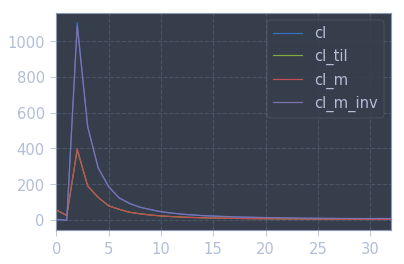

In [44]:
df.plot()
plt.show()

(2, 32)

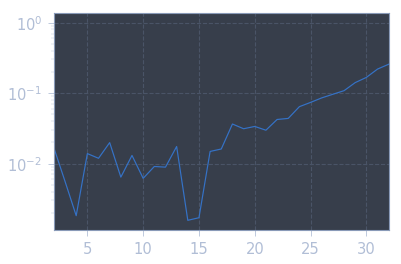

In [48]:
plt.plot(np.abs(df.cl-df.cl_m_inv)/df.cl_m_inv)
plt.yscale('log')
%plt.xlim(2,lmax)

In [53]:
%%timeit
ms.master_matrix(wl)

29.8 s ± 131 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [52]:
np.all(m_mod == m_inv)

True

In [56]:
import time

time_list = []

for lmaxx in np.arange(10,lmax):
    to = time.time()
    minv = ms.master_matrix(wl,lmaxx)
    dt = time.time() - to
    time_list.append([lmaxx,dt])

In [70]:
time_list 

[11, 0.41372013092041016]

In [71]:
#time_list = np.array(time_list)[1:]

#time_list = [i for i in time_list]

In [74]:
time_list = np.array(time_list)

In [76]:
time_list.T

array([[ 11.        ,  12.        ,  13.        ,  14.        ,
         15.        ,  16.        ,  17.        ,  18.        ,
         19.        ,  20.        ,  21.        ,  22.        ,
         23.        ,  24.        ,  25.        ,  26.        ,
         27.        ,  28.        ,  29.        ,  30.        ,  31.        ],
       [  0.41372013,   0.56322074,   0.77802801,   0.89616489,
          1.20422816,   1.73655748,   2.46721458,   3.1100204 ,
          4.15796876,   4.73708105,   5.71457648,   6.64304733,
          7.88400459,   9.54515433,  12.05266786,  13.17577243,
         14.87543559,  16.4520154 ,  21.31468058,  25.55587268,
         34.04932475]])

In [73]:
time_list.T

AttributeError: 'list' object has no attribute 'T'

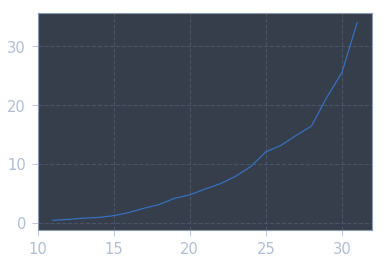

In [77]:
plt.plot(time_list.T[0],time_list.T[1])

In [79]:
np.polyfit(time_list.T[0],time_list.T[1],2)

array([  0.10318597,  -2.98224865,  22.25904726])

In [80]:
def time(l):
    return 0.103*l**2 -2.93*l + 22.25

In [84]:
time(3000)/60

15303.870833333332